In [1]:
!pip install mxnet=="1.4.1"

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install gluonts

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
# !pip install gluonts=="0.4.1"

In [86]:
import gluonts
gluonts.__version__

'0.4.2'

In [87]:
import mxnet
mxnet.__version__

'1.4.1'

In [7]:
# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes
from utils_gluonts10_deepar import deepar
# from utils_gluonts11_deepstate import deep_state


INFO:root:Using CPU


In [8]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_daily', 'm4_hourly', 'm4_monthly', 'm4_monthly_atm', 'm4_monthly_dates', 'm4_monthly_demographic', 'm4_monthly_finance', 'm4_monthly_industry', 'm4_monthly_macro', 'm4_monthly_micro', 'm4_monthly_other', 'm4_quarterly', 'm4_quarterly_atm', 'm4_quarterly_dates', 'm4_quarterly_demographic', 'm4_quarterly_finance', 'm4_quarterly_industry', 'm4_quarterly_macro', 'm4_quarterly_micro', 'm4_quarterly_other', 'm4_weekly', 'my_weekly_tm', 'm4_yearly', 'm4_yearly_industry', 'm4_yearly_macro', 'm4_yearly_micro']


#### Note

In SageMaker data are saved into the following folders (example shows m4_weekly):

```
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly/train/data.json
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly/test/data.json
```

In [9]:
dataname = "m4_monthly_other"
dataset = get_dataset(dataname, regenerate=False)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_other.


In [10]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))
test_entry = next(iter(dataset.test))

# check keys
print(train_entry.keys())
print(test_entry.keys())

dict_keys(['start', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'target', 'feat_static_cat', 'source'])


In [11]:
train_entry

{'start': Timestamp('1750-01-31 00:00:00', freq='M'),
 'target': array([  504.63,   498.05,   497.33,   500.58,   501.12,   503.37,
          508.02,   506.61,   507.22,   506.6 ,   508.77,   515.04,
          506.61,   496.09,   494.82,   496.56,   497.34,   500.15,
          504.55,   502.79,   499.2 ,   501.3 ,   502.51,   497.63,
          491.03,   484.41,   483.62,   484.55,   484.94,   488.75,
          492.16,   493.34,   495.99,   500.32,   504.84,   512.81,
          506.03,   498.41,   500.24,   503.65,   505.43,   509.08,
          513.14,   511.75,   513.22,   515.52,   513.44,   522.57,
          516.35,   510.13,   512.06,   514.89,   517.02,   521.95,
          527.68,   526.  ,   529.1 ,   531.17,   537.75,   549.13,
          542.38,   534.72,   538.3 ,   540.52,   542.73,   549.4 ,
          554.26,   554.27,   558.87,   561.62,   567.86,   577.37,
          571.38,   565.08,   566.96,   570.89,   571.65,   577.61,
          584.07,   581.92,   585.74,   591.37,   59

In [12]:
len(dataset.train)

277

## Plot Series

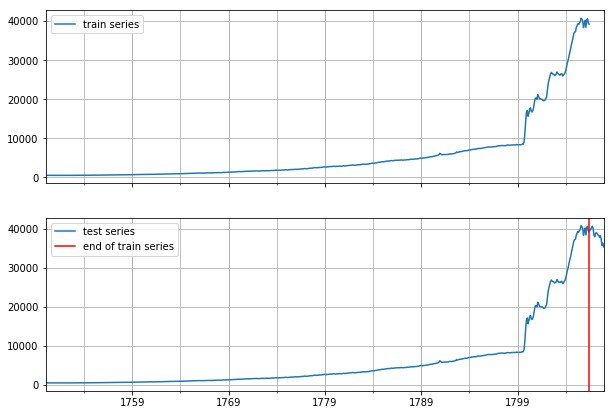

In [13]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [15]:
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

from gluonts.model.deepstate import DeepStateEstimator

INFO:root:Using CPU


In [18]:
#########################
### deepstate wrapper ###

data = "m4_monthly_other"
seed = 42
epochs = 100
batches = 50

mx.random.seed(seed)
np.random.seed(seed)

dataset = get_dataset(data)

trainer = Trainer(
    ctx=mx.cpu(0),
#     ctx=mx.gpu(0),
    epochs=epochs,
    num_batches_per_epoch=batches,
    learning_rate=1e-3,
    )

cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)

cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)
estimator = DeepStateEstimator(
    trainer=trainer,
    cardinality=[cardinality],
    prediction_length=dataset.metadata.prediction_length,
    freq=dataset.metadata.freq,
    use_feat_static_cat=True,
    )

predictor=estimator.train(dataset.train)

forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

agg_metrics, item_metrics = Evaluator()(
    ts_it, forecast_it, num_series=len(dataset.test)
)

metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}
output["epochs"] = epochs
output["seed"] = seed
output["epochs"] = epochs
output["num_batches"] = batches

pd.DataFrame([output])

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_other.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.51it/s, avg_epoch_loss=0.244]
INFO:root:Epoch[0] Elapsed time 5.257 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.243684
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 10.07it/s, avg_epoch_loss=-.231]
INFO:root:Epoch[1] Elapsed time 4.965 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=-0.231301
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.94it/s, avg_epoch_loss=-.66]
INFO:root:Epoch[2] Elapsed time 5.031 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=-0.660045
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 10.14it/s, avg_epoch_loss=-.72]
INFO:root:Epoch[3] Elapsed time 4.935 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-0

100%|██████████| 50/50 [00:04<00:00, 10.02it/s, avg_epoch_loss=-1.92]
INFO:root:Epoch[36] Elapsed time 4.990 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=-1.923234
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 10.02it/s, avg_epoch_loss=-1.86]
INFO:root:Epoch[37] Elapsed time 4.992 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-1.862714
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.99it/s, avg_epoch_loss=-1.94]
INFO:root:Epoch[38] Elapsed time 5.005 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-1.935991
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.94it/s, avg_epoch_loss=-1.99]
INFO:root:Epoch[39] Elapsed time 5.032 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-1.988957
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 10.08it/s, avg_epoch_loss=-1.97]
INFO:root:Epoch[40] Elapsed time 4.961 seconds

,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],epochs,seed,num_batches
0,1.137234,0.147284,27.783618,0.127894,0.10034,100,42,50


In [19]:
#########################
### deepstate wrapper ###

data = "m4_monthly_other"
seed = 43
epochs = 100
batches = 50

mx.random.seed(seed)
np.random.seed(seed)

dataset = get_dataset(data)

trainer = Trainer(
    ctx=mx.cpu(0),
#     ctx=mx.gpu(0),
    epochs=epochs,
    num_batches_per_epoch=batches,
    learning_rate=1e-3,
    )

cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)

cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)
estimator = DeepStateEstimator(
    trainer=trainer,
    cardinality=[cardinality],
    prediction_length=dataset.metadata.prediction_length,
    freq=dataset.metadata.freq,
    use_feat_static_cat=True,
    )

predictor=estimator.train(dataset.train)

forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

agg_metrics, item_metrics = Evaluator()(
    ts_it, forecast_it, num_series=len(dataset.test)
)

metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}
output["epochs"] = epochs
output["seed"] = seed
output["epochs"] = epochs
output["num_batches"] = batches

pd.DataFrame([output])

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_other.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.50it/s, avg_epoch_loss=0.204]
INFO:root:Epoch[0] Elapsed time 5.264 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.203764
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 10.12it/s, avg_epoch_loss=-.34]
INFO:root:Epoch[1] Elapsed time 4.941 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=-0.339733
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 10.04it/s, avg_epoch_loss=-.701]
INFO:root:Epoch[2] Elapsed time 4.984 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=-0.700905
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 10.11it/s, avg_epoch_loss=-.774]
INFO:root:Epoch[3] Elapsed time 4.947 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-

100%|██████████| 50/50 [00:04<00:00, 10.01it/s, avg_epoch_loss=-1.91]
INFO:root:Epoch[36] Elapsed time 4.998 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=-1.905394
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.93it/s, avg_epoch_loss=-1.88]
INFO:root:Epoch[37] Elapsed time 5.040 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-1.880364
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.93it/s, avg_epoch_loss=-1.91]
INFO:root:Epoch[38] Elapsed time 5.039 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-1.907792
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.88it/s, avg_epoch_loss=-2.02]
INFO:root:Epoch[39] Elapsed time 5.061 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-2.022848
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.98it/s, avg_epoch_loss=-1.95]
INFO:root:Epoch[40] Elapsed time 5.011 seconds

,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],epochs,seed,num_batches
0,1.116013,0.140723,23.749433,0.12551,0.08392,100,43,50


In [20]:
#########################
### deepstate wrapper ###

data = "m4_monthly_other"
seed = 44
epochs = 100
batches = 50

mx.random.seed(seed)
np.random.seed(seed)

dataset = get_dataset(data)

trainer = Trainer(
    ctx=mx.cpu(0),
#     ctx=mx.gpu(0),
    epochs=epochs,
    num_batches_per_epoch=batches,
    learning_rate=1e-3,
    )

cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)

cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)
estimator = DeepStateEstimator(
    trainer=trainer,
    cardinality=[cardinality],
    prediction_length=dataset.metadata.prediction_length,
    freq=dataset.metadata.freq,
    use_feat_static_cat=True,
    )

predictor=estimator.train(dataset.train)

forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

agg_metrics, item_metrics = Evaluator()(
    ts_it, forecast_it, num_series=len(dataset.test)
)

metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}

output["seed"] = seed
output["epochs"] = epochs
output["num_batches"] = batches

pd.DataFrame([output])

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_other.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.44it/s, avg_epoch_loss=0.223]
INFO:root:Epoch[0] Elapsed time 5.298 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.223042
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 10.06it/s, avg_epoch_loss=-.313]
INFO:root:Epoch[1] Elapsed time 4.974 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=-0.312840
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.95it/s, avg_epoch_loss=-.683]
INFO:root:Epoch[2] Elapsed time 5.026 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=-0.683182
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 10.01it/s, avg_epoch_loss=-.747]
INFO:root:Epoch[3] Elapsed time 4.998 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=

100%|██████████| 50/50 [00:04<00:00, 10.15it/s, avg_epoch_loss=-1.87]
INFO:root:Epoch[36] Elapsed time 4.927 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=-1.867336
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 10.12it/s, avg_epoch_loss=-1.87]
INFO:root:Epoch[37] Elapsed time 4.944 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-1.870665
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 10.15it/s, avg_epoch_loss=-1.87]
INFO:root:Epoch[38] Elapsed time 4.929 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-1.872562
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.45it/s, avg_epoch_loss=-2]
INFO:root:Epoch[39] Elapsed time 5.293 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-2.001897
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  8.42it/s, avg_epoch_loss=-1.93]
INFO:root:Epoch[40] Elapsed time 5.940 seconds
IN

,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],epochs,seed,num_batches
0,0.96971,0.131699,20.010037,0.108365,0.069145,100,44,50


### Change in `num_batches`

In [21]:
#########################
### deepstate wrapper ###

data = "m4_monthly_other"
seed = 42
epochs = 100
batches = 100

mx.random.seed(seed)
np.random.seed(seed)

dataset = get_dataset(data)

trainer = Trainer(
    ctx=mx.cpu(0),
#     ctx=mx.gpu(0),
    epochs=epochs,
    num_batches_per_epoch=batches,
    learning_rate=1e-3,
    )

cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)

cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)
estimator = DeepStateEstimator(
    trainer=trainer,
    cardinality=[cardinality],
    prediction_length=dataset.metadata.prediction_length,
    freq=dataset.metadata.freq,
    use_feat_static_cat=True,
    )

predictor=estimator.train(dataset.train)

forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

agg_metrics, item_metrics = Evaluator()(
    ts_it, forecast_it, num_series=len(dataset.test)
)

metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}
output["epochs"] = epochs
output["seed"] = seed
output["epochs"] = epochs
output["num_batches"] = batches

pd.DataFrame([output])

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_other.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.74it/s, avg_epoch_loss=0.00619]
INFO:root:Epoch[0] Elapsed time 10.271 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.006192
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 10.09it/s, avg_epoch_loss=-.69]
INFO:root:Epoch[1] Elapsed time 9.915 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=-0.689815
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.97it/s, avg_epoch_loss=-.955]
INFO:root:Epoch[2] Elapsed time 10.035 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=-0.954956
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 10.03it/s, avg_epoch_loss=-1.26]
INFO:root:Epoch[3] Elapsed time 9.970 seconds
INFO:root:Epoch[3] Evaluation metric 'e

INFO:root:Epoch[35] Evaluation metric 'epoch_loss'=-2.153200
INFO:root:Epoch[36] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.97it/s, avg_epoch_loss=-2.15]
INFO:root:Epoch[36] Elapsed time 10.031 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=-2.152861
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.86it/s, avg_epoch_loss=-2.15]
INFO:root:Epoch[37] Elapsed time 10.142 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-2.149585
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.90it/s, avg_epoch_loss=-2.17]
INFO:root:Epoch[38] Elapsed time 10.101 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-2.172420
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.84it/s, avg_epoch_loss=-2.18]
INFO:root:Epoch[39] Elapsed time 10.160 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-2.180752
INFO:root:Epoch[40] Learning rate is 0.001


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],epochs,seed,num_batches
0,1.144108,0.145212,31.557066,0.129533,0.111709,100,42,100


In [22]:
#########################
### deepstate wrapper ###

data = "m4_monthly_other"
seed = 43
epochs = 100
batches = 100

mx.random.seed(seed)
np.random.seed(seed)

dataset = get_dataset(data)

trainer = Trainer(
    ctx=mx.cpu(0),
#     ctx=mx.gpu(0),
    epochs=epochs,
    num_batches_per_epoch=batches,
    learning_rate=1e-3,
    )

cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)

cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)
estimator = DeepStateEstimator(
    trainer=trainer,
    cardinality=[cardinality],
    prediction_length=dataset.metadata.prediction_length,
    freq=dataset.metadata.freq,
    use_feat_static_cat=True,
    )

predictor=estimator.train(dataset.train)

forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

agg_metrics, item_metrics = Evaluator()(
    ts_it, forecast_it, num_series=len(dataset.test)
)

metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}
output["epochs"] = epochs
output["seed"] = seed
output["epochs"] = epochs
output["num_batches"] = batches

pd.DataFrame([output])

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_other.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.66it/s, avg_epoch_loss=-.068]
INFO:root:Epoch[0] Elapsed time 10.349 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=-0.067985
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.93it/s, avg_epoch_loss=-.737]
INFO:root:Epoch[1] Elapsed time 10.078 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=-0.737318
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.93it/s, avg_epoch_loss=-1]
INFO:root:Epoch[2] Elapsed time 10.068 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=-1.000022
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.99it/s, avg_epoch_loss=-1.24]
INFO:root:Epoch[3] Elapsed time 10.010 seconds
INFO:root:Epoch[3] Evaluation metric 'ep

INFO:root:Epoch[35] Evaluation metric 'epoch_loss'=-2.103928
INFO:root:Epoch[36] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.97it/s, avg_epoch_loss=-2.15]
INFO:root:Epoch[36] Elapsed time 10.037 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=-2.151284
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 10.04it/s, avg_epoch_loss=-2.12]
INFO:root:Epoch[37] Elapsed time 9.963 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-2.115103
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 10.01it/s, avg_epoch_loss=-2.01]
INFO:root:Epoch[38] Elapsed time 9.994 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-2.010616
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.99it/s, avg_epoch_loss=-2.07]
INFO:root:Epoch[39] Elapsed time 10.009 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-2.073636
INFO:root:Epoch[40] Learning rate is 0.001
10

,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],epochs,seed,num_batches
0,1.08058,0.143485,26.358661,0.118878,0.086309,100,43,100


In [23]:
#########################
### deepstate wrapper ###

data = "m4_monthly_other"
seed = 44
epochs = 100
batches = 100

mx.random.seed(seed)
np.random.seed(seed)

dataset = get_dataset(data)

trainer = Trainer(
    ctx=mx.cpu(0),
#     ctx=mx.gpu(0),
    epochs=epochs,
    num_batches_per_epoch=batches,
    learning_rate=1e-3,
    )

cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)

cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)
estimator = DeepStateEstimator(
    trainer=trainer,
    cardinality=[cardinality],
    prediction_length=dataset.metadata.prediction_length,
    freq=dataset.metadata.freq,
    use_feat_static_cat=True,
    )

predictor=estimator.train(dataset.train)

forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

agg_metrics, item_metrics = Evaluator()(
    ts_it, forecast_it, num_series=len(dataset.test)
)

metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}
output["epochs"] = epochs
output["seed"] = seed
output["epochs"] = epochs
output["num_batches"] = batches

pd.DataFrame([output])

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_other.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.75it/s, avg_epoch_loss=-.0449]
INFO:root:Epoch[0] Elapsed time 10.261 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=-0.044899
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 10.11it/s, avg_epoch_loss=-.715]
INFO:root:Epoch[1] Elapsed time 9.891 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=-0.715079
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 10.01it/s, avg_epoch_loss=-.939]
INFO:root:Epoch[2] Elapsed time 9.996 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=-0.939170
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 10.05it/s, avg_epoch_loss=-1.22]
INFO:root:Epoch[3] Elapsed time 9.951 seconds
INFO:root:Epoch[3] Evaluation metric 'e

INFO:root:Epoch[36] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 10.09it/s, avg_epoch_loss=-2.12]
INFO:root:Epoch[36] Elapsed time 9.910 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=-2.116509
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 10.05it/s, avg_epoch_loss=-2.11]
INFO:root:Epoch[37] Elapsed time 9.957 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-2.109503
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 10.01it/s, avg_epoch_loss=-2.15]
INFO:root:Epoch[38] Elapsed time 9.996 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-2.146697
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 10.03it/s, avg_epoch_loss=-2.1]
INFO:root:Epoch[39] Elapsed time 9.976 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-2.102749
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 10.05it/s, avg_epoch_loss=-

INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=-2.361325
INFO:root:Epoch[73] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 10.08it/s, avg_epoch_loss=-2.31]
INFO:root:Epoch[73] Elapsed time 9.924 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=-2.310000
INFO:root:Epoch[74] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 10.09it/s, avg_epoch_loss=-2.4]
INFO:root:Epoch[74] Elapsed time 9.913 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-2.402984
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 10.17it/s, avg_epoch_loss=-2.37]
INFO:root:Epoch[75] Elapsed time 9.836 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-2.366567
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 10.07it/s, avg_epoch_loss=-2.37]
INFO:root:Epoch[76] Elapsed time 9.937 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=-2.373886
INFO:root:Epoch[77] Learning rate is 0.001
100%|

,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],epochs,seed,num_batches
0,1.06876,0.136992,25.671219,0.115765,0.079544,100,44,100


### Change in batch_size

In [24]:
#########################
### deepstate wrapper ###

data = "m4_monthly_other"
seed = 42
epochs = 100
batches = 100

mx.random.seed(seed)
np.random.seed(seed)

dataset = get_dataset(data)

trainer = Trainer(
    ctx=mx.cpu(0),
#     ctx=mx.gpu(0),
    epochs=epochs,
    num_batches_per_epoch=batches,
    learning_rate=1e-3,
    batch_size=64
    )

cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)

cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)
estimator = DeepStateEstimator(
    trainer=trainer,
    cardinality=[cardinality],
    prediction_length=dataset.metadata.prediction_length,
    freq=dataset.metadata.freq,
    use_feat_static_cat=True,
    )

predictor=estimator.train(dataset.train)

forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

agg_metrics, item_metrics = Evaluator()(
    ts_it, forecast_it, num_series=len(dataset.test)
)

metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}
output["epochs"] = epochs
output["seed"] = seed
output["epochs"] = epochs
output["num_batches"] = batches

pd.DataFrame([output])

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_other.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:18<00:00,  5.53it/s, avg_epoch_loss=-.109]
INFO:root:Epoch[0] Elapsed time 18.094 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=-0.108780
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.87it/s, avg_epoch_loss=-.736]
INFO:root:Epoch[1] Elapsed time 17.050 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=-0.736425
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.81it/s, avg_epoch_loss=-1.12]
INFO:root:Epoch[2] Elapsed time 17.205 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=-1.119486
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.83it/s, avg_epoch_loss=-1.42]
INFO:root:Epoch[3] Elapsed time 17.147 seconds
INFO:root:Epoch[3] Evaluation metric 

INFO:root:Epoch[35] Evaluation metric 'epoch_loss'=-2.230133
INFO:root:Epoch[36] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.79it/s, avg_epoch_loss=-2.22]
INFO:root:Epoch[36] Elapsed time 17.280 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=-2.223129
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.79it/s, avg_epoch_loss=-2.24]
INFO:root:Epoch[37] Elapsed time 17.273 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-2.242944
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.84it/s, avg_epoch_loss=-2.26]
INFO:root:Epoch[38] Elapsed time 17.134 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-2.256545
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.85it/s, avg_epoch_loss=-2.26]
INFO:root:Epoch[39] Elapsed time 17.104 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-2.256385
INFO:root:Epoch[40] Learning rate is 0.001


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],epochs,seed,num_batches
0,1.096111,0.140904,28.650159,0.121949,0.095983,100,42,100


In [25]:
#########################
### deepstate wrapper ###

data = "m4_monthly_other"
seed = 43
epochs = 100
batches = 100

mx.random.seed(seed)
np.random.seed(seed)

dataset = get_dataset(data)

trainer = Trainer(
    ctx=mx.cpu(0),
#     ctx=mx.gpu(0),
    epochs=epochs,
    num_batches_per_epoch=batches,
    learning_rate=1e-3,
    batch_size=64
    )

cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)

cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)
estimator = DeepStateEstimator(
    trainer=trainer,
    cardinality=[cardinality],
    prediction_length=dataset.metadata.prediction_length,
    freq=dataset.metadata.freq,
    use_feat_static_cat=True,
    )

predictor=estimator.train(dataset.train)

forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

agg_metrics, item_metrics = Evaluator()(
    ts_it, forecast_it, num_series=len(dataset.test)
)

metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}
output["epochs"] = epochs
output["seed"] = seed
output["epochs"] = epochs
output["num_batches"] = batches

pd.DataFrame([output])

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_other.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.70it/s, avg_epoch_loss=-.153]
INFO:root:Epoch[0] Elapsed time 17.550 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=-0.152741
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.82it/s, avg_epoch_loss=-.769]
INFO:root:Epoch[1] Elapsed time 17.171 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=-0.768744
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.78it/s, avg_epoch_loss=-1.1]
INFO:root:Epoch[2] Elapsed time 17.313 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=-1.104321
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.82it/s, avg_epoch_loss=-1.37]
INFO:root:Epoch[3] Elapsed time 17.174 seconds
INFO:root:Epoch[3] Evaluation metric '

INFO:root:Epoch[35] Evaluation metric 'epoch_loss'=-2.203248
INFO:root:Epoch[36] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.74it/s, avg_epoch_loss=-2.21]
INFO:root:Epoch[36] Elapsed time 17.416 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=-2.212717
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.77it/s, avg_epoch_loss=-2.2]
INFO:root:Epoch[37] Elapsed time 17.329 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-2.202161
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.75it/s, avg_epoch_loss=-2.25]
INFO:root:Epoch[38] Elapsed time 17.393 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-2.246936
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.76it/s, avg_epoch_loss=-2.24]
INFO:root:Epoch[39] Elapsed time 17.352 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-2.235288
INFO:root:Epoch[40] Learning rate is 0.001
1

,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],epochs,seed,num_batches
0,1.213871,0.15177,32.522351,0.134,0.121309,100,43,100


In [26]:
#########################
### deepstate wrapper ###

data = "m4_monthly_other"
seed = 44
epochs = 100
batches = 100

mx.random.seed(seed)
np.random.seed(seed)

dataset = get_dataset(data)

trainer = Trainer(
    ctx=mx.cpu(0),
#     ctx=mx.gpu(0),
    epochs=epochs,
    num_batches_per_epoch=batches,
    learning_rate=1e-3,
    batch_size=64
    )

cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)

cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)
estimator = DeepStateEstimator(
    trainer=trainer,
    cardinality=[cardinality],
    prediction_length=dataset.metadata.prediction_length,
    freq=dataset.metadata.freq,
    use_feat_static_cat=True,
    )

predictor=estimator.train(dataset.train)

forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

agg_metrics, item_metrics = Evaluator()(
    ts_it, forecast_it, num_series=len(dataset.test)
)

metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}
output["epochs"] = epochs
output["seed"] = seed
output["epochs"] = epochs
output["num_batches"] = batches

pd.DataFrame([output])

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_other.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.68it/s, avg_epoch_loss=-.129]
INFO:root:Epoch[0] Elapsed time 17.605 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=-0.128850
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.79it/s, avg_epoch_loss=-.737]
INFO:root:Epoch[1] Elapsed time 17.268 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=-0.736943
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.74it/s, avg_epoch_loss=-1.07]
INFO:root:Epoch[2] Elapsed time 17.423 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=-1.065454
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.77it/s, avg_epoch_loss=-1.34]
INFO:root:Epoch[3] Elapsed time 17.329 seconds
INFO:root:Epoch[3] Evaluation metric 

INFO:root:Epoch[35] Evaluation metric 'epoch_loss'=-2.178379
INFO:root:Epoch[36] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.76it/s, avg_epoch_loss=-2.19]
INFO:root:Epoch[36] Elapsed time 17.350 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=-2.194036
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.68it/s, avg_epoch_loss=-2.21]
INFO:root:Epoch[37] Elapsed time 17.596 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-2.206211
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.59it/s, avg_epoch_loss=-2.22]
INFO:root:Epoch[38] Elapsed time 17.899 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-2.215379
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.73it/s, avg_epoch_loss=-2.22]
INFO:root:Epoch[39] Elapsed time 17.465 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-2.222805
INFO:root:Epoch[40] Learning rate is 0.001


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],epochs,seed,num_batches
0,1.064714,0.142794,25.879952,0.114981,0.082635,100,44,100


### New dataset: `m4_monthly_finance`

In [74]:
dataname = "m4_monthly_finance"
dataset = get_dataset(dataname, regenerate=False)

# get the first time series in the training set
train_entry = next(iter(dataset.train))
test_entry = next(iter(dataset.test))

# check keys
print(train_entry.keys())
print(test_entry.keys())

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_finance.


dict_keys(['start', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'target', 'feat_static_cat', 'source'])


In [75]:
print("start", dict(train_entry)["start"])
print("target:", dict(train_entry)["target"][:10])
print("feat_static_cat:", dict(train_entry)["feat_static_cat"])
print("length:", len(dataset.train))

start 1750-01-31 00:00:00
target: [4964. 4963. 4964. 4964. 4959. 4973. 4967. 4915. 4780. 4686.]
feat_static_cat: [1]
length: 10987


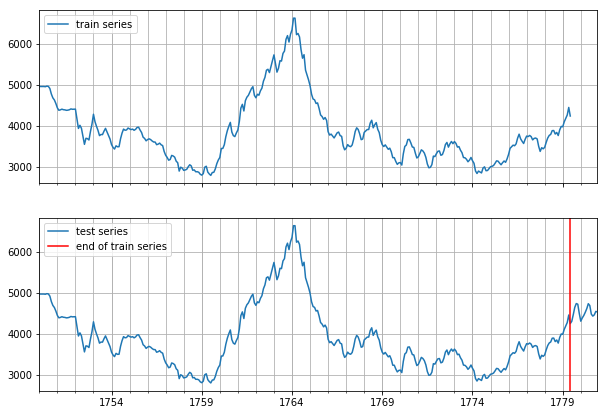

In [76]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [77]:
#########################
### deepstate wrapper ###

data = "m4_monthly_finance"
seed = 42
epochs = 100
batches = 50

mx.random.seed(seed)
np.random.seed(seed)

dataset = get_dataset(data)

trainer = Trainer(
    ctx=mx.cpu(0),
#     ctx=mx.gpu(0),
    epochs=epochs,
    num_batches_per_epoch=batches,
    learning_rate=1e-3,
    batch_size=32
    )

cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)

cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)
estimator = DeepStateEstimator(
    trainer=trainer,
    cardinality=[cardinality],
    prediction_length=dataset.metadata.prediction_length,
    freq=dataset.metadata.freq,
    use_feat_static_cat=True,
    )

predictor=estimator.train(dataset.train)

forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

agg_metrics, item_metrics = Evaluator()(
    ts_it, forecast_it, num_series=len(dataset.test)
)

metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}
output["epochs"] = epochs
output["seed"] = seed
output["epochs"] = epochs
output["num_batches"] = batches

pd.DataFrame([output])

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_finance.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  8.99it/s, avg_epoch_loss=0.273]
INFO:root:Epoch[0] Elapsed time 5.562 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.273251
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.83it/s, avg_epoch_loss=0.607]
INFO:root:Epoch[1] Elapsed time 5.087 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.606781
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.82it/s, avg_epoch_loss=0.193]
INFO:root:Epoch[2] Elapsed time 5.094 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.193473
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.74it/s, avg_epoch_loss=0.407]
INFO:root:Epoch[3] Elapsed time 5.135 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=

100%|██████████| 50/50 [00:05<00:00,  9.81it/s, avg_epoch_loss=-.929]
INFO:root:Epoch[36] Elapsed time 5.098 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=-0.928606
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.74it/s, avg_epoch_loss=-.97]
INFO:root:Epoch[37] Elapsed time 5.138 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-0.969514
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.79it/s, avg_epoch_loss=-.779]
INFO:root:Epoch[38] Elapsed time 5.108 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-0.779245
INFO:root:Loading parameters from best epoch (28)
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 50/50 [00:05<00:00,  9.83it/s, avg_epoch_loss=-.474]
INFO:root:Epoch[39] Elapsed time 5.091 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-0.474155
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 50/50 [00:05<00:00,  9.85it/s, avg_epoch_loss=-.

,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],epochs,seed,num_batches
0,1.232293,0.174863,19.907909,0.162483,0.114179,100,42,50


In [78]:
#########################
### deepstate wrapper ###

data = "m4_monthly_finance"
seed = 43
epochs = 100
batches = 50

mx.random.seed(seed)
np.random.seed(seed)

dataset = get_dataset(data)

trainer = Trainer(
    ctx=mx.cpu(0),
#     ctx=mx.gpu(0),
    epochs=epochs,
    num_batches_per_epoch=batches,
    learning_rate=1e-3,
    batch_size=32
    )

cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)

cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)
estimator = DeepStateEstimator(
    trainer=trainer,
    cardinality=[cardinality],
    prediction_length=dataset.metadata.prediction_length,
    freq=dataset.metadata.freq,
    use_feat_static_cat=True,
    )

predictor=estimator.train(dataset.train)

forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

agg_metrics, item_metrics = Evaluator()(
    ts_it, forecast_it, num_series=len(dataset.test)
)

metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}
output["epochs"] = epochs
output["seed"] = seed
output["epochs"] = epochs
output["num_batches"] = batches

pd.DataFrame([output])

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_finance.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  8.95it/s, avg_epoch_loss=-.181]
INFO:root:Epoch[0] Elapsed time 5.586 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=-0.181451
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.77it/s, avg_epoch_loss=0.229]
INFO:root:Epoch[1] Elapsed time 5.118 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.229336
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.72it/s, avg_epoch_loss=0.137]
INFO:root:Epoch[2] Elapsed time 5.147 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.137251
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.77it/s, avg_epoch_loss=0.39]
INFO:root:Epoch[3] Elapsed time 5.122 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=

100%|██████████| 50/50 [00:05<00:00,  9.93it/s, avg_epoch_loss=-.927]
INFO:root:Epoch[36] Elapsed time 5.039 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=-0.926879
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.89it/s, avg_epoch_loss=-1.02]
INFO:root:Epoch[37] Elapsed time 5.060 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-1.015866
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.89it/s, avg_epoch_loss=-.835]
INFO:root:Epoch[38] Elapsed time 5.060 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-0.834909
INFO:root:Loading parameters from best epoch (28)
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 50/50 [00:05<00:00,  9.89it/s, avg_epoch_loss=-.46]
INFO:root:Epoch[39] Elapsed time 5.059 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-0.460246
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 50/50 [00:05<00:00,  9.94it/s, avg_epoch_loss=-.

,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],epochs,seed,num_batches
0,1.247957,0.175719,19.419625,0.163246,0.113192,100,43,50


In [79]:
#########################
### deepstate wrapper ###

data = "m4_monthly_finance"
seed = 44
epochs = 100
batches = 50

mx.random.seed(seed)
np.random.seed(seed)

dataset = get_dataset(data)

trainer = Trainer(
    ctx=mx.cpu(0),
#     ctx=mx.gpu(0),
    epochs=epochs,
    num_batches_per_epoch=batches,
    learning_rate=1e-3,
    batch_size=32
    )

cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)

cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)
estimator = DeepStateEstimator(
    trainer=trainer,
    cardinality=[cardinality],
    prediction_length=dataset.metadata.prediction_length,
    freq=dataset.metadata.freq,
    use_feat_static_cat=True,
    )

predictor=estimator.train(dataset.train)

forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

agg_metrics, item_metrics = Evaluator()(
    ts_it, forecast_it, num_series=len(dataset.test)
)

metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}
output["epochs"] = epochs
output["seed"] = seed
output["epochs"] = epochs
output["num_batches"] = batches

pd.DataFrame([output])

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_finance.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.08it/s, avg_epoch_loss=-.168]
INFO:root:Epoch[0] Elapsed time 5.513 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=-0.168201
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.83it/s, avg_epoch_loss=0.27]
INFO:root:Epoch[1] Elapsed time 5.088 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.270199
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.83it/s, avg_epoch_loss=0.158]
INFO:root:Epoch[2] Elapsed time 5.088 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.157767
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.75it/s, avg_epoch_loss=0.421]
INFO:root:Epoch[3] Elapsed time 5.133 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=

100%|██████████| 50/50 [00:05<00:00,  9.84it/s, avg_epoch_loss=-.885]
INFO:root:Epoch[36] Elapsed time 5.084 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=-0.884814
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.83it/s, avg_epoch_loss=-.945]
INFO:root:Epoch[37] Elapsed time 5.091 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-0.944646
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.93it/s, avg_epoch_loss=-.771]
INFO:root:Epoch[38] Elapsed time 5.040 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-0.770886
INFO:root:Loading parameters from best epoch (28)
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 50/50 [00:05<00:00,  9.94it/s, avg_epoch_loss=-.446]
INFO:root:Epoch[39] Elapsed time 5.030 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-0.445855
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 50/50 [00:05<00:00,  9.93it/s, avg_epoch_loss=-

100%|██████████| 50/50 [00:05<00:00,  9.95it/s, avg_epoch_loss=-.529]
INFO:root:Epoch[72] Elapsed time 5.028 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=-0.529037
INFO:root:Epoch[73] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:05<00:00,  9.95it/s, avg_epoch_loss=-.763]
INFO:root:Epoch[73] Elapsed time 5.028 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=-0.762572
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:05<00:00,  9.94it/s, avg_epoch_loss=-.34]
INFO:root:Epoch[74] Elapsed time 5.034 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-0.339600
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:05<00:00,  9.86it/s, avg_epoch_loss=-.288]
INFO:root:Epoch[75] Elapsed time 5.074 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-0.287820
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:05<00:00,  9.86it/s, avg_epoch_loss=-1.86]
INFO:root:Epoch[76] Elapsed time 5.

,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],epochs,seed,num_batches
0,1.177497,0.164941,25.232595,0.152969,0.124411,100,44,50


# Epochs=100, num_batches=100

In [80]:
#########################
### deepstate wrapper ###

data = "m4_monthly_finance"
seed = 42
epochs = 100
batches = 100

mx.random.seed(seed)
np.random.seed(seed)

dataset = get_dataset(data)

trainer = Trainer(
    ctx=mx.cpu(0),
#     ctx=mx.gpu(0),
    epochs=epochs,
    num_batches_per_epoch=batches,
    learning_rate=1e-3,
    batch_size=32
    )

cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)

cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)
estimator = DeepStateEstimator(
    trainer=trainer,
    cardinality=[cardinality],
    prediction_length=dataset.metadata.prediction_length,
    freq=dataset.metadata.freq,
    use_feat_static_cat=True,
    )

predictor=estimator.train(dataset.train)

forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

agg_metrics, item_metrics = Evaluator()(
    ts_it, forecast_it, num_series=len(dataset.test)
)

metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}

output["epochs"] = epochs
output["seed"] = seed
output["epochs"] = epochs
output["num_batches"] = batches

pd.DataFrame([output])

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_finance.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.32it/s, avg_epoch_loss=0.44]
INFO:root:Epoch[0] Elapsed time 10.728 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.440016
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.21it/s, avg_epoch_loss=0.3] 
INFO:root:Epoch[1] Elapsed time 10.862 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.300434
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.72it/s, avg_epoch_loss=0.385]
INFO:root:Epoch[2] Elapsed time 10.293 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.384542
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.73it/s, avg_epoch_loss=0.114]
INFO:root:Epoch[3] Elapsed time 10.280 seconds
INFO:root:Epoch[3] Evaluation metric 'ep

INFO:root:Epoch[35] Evaluation metric 'epoch_loss'=-1.317289
INFO:root:Epoch[36] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.67it/s, avg_epoch_loss=-1.06]
INFO:root:Epoch[36] Elapsed time 10.340 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=-1.056546
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.79it/s, avg_epoch_loss=-.772]
INFO:root:Epoch[37] Elapsed time 10.221 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-0.772003
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.75it/s, avg_epoch_loss=-1.89]
INFO:root:Epoch[38] Elapsed time 10.262 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-1.891417
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.75it/s, avg_epoch_loss=-1.2]
INFO:root:Epoch[39] Elapsed time 10.259 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-1.197068
INFO:root:Epoch[40] Learning rate is 0.001
1

INFO:root:Epoch[71] Evaluation metric 'epoch_loss'=-0.800599
INFO:root:Epoch[72] Learning rate is 0.00025
100%|██████████| 100/100 [00:10<00:00,  9.76it/s, avg_epoch_loss=-2.13]
INFO:root:Epoch[72] Elapsed time 10.253 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=-2.132735
INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 100/100 [00:10<00:00,  9.78it/s, avg_epoch_loss=-1.34]
INFO:root:Epoch[73] Elapsed time 10.232 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=-1.337943
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:10<00:00,  9.80it/s, avg_epoch_loss=-1.12]
INFO:root:Epoch[74] Elapsed time 10.205 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-1.116264
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:10<00:00,  9.73it/s, avg_epoch_loss=-1.38]
INFO:root:Epoch[75] Elapsed time 10.277 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-1.380438
INFO:root:Loading parameters from b

,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],epochs,seed,num_batches
0,1.198969,0.164984,19.436844,0.156761,0.101368,100,42,100


In [81]:
#########################
### deepstate wrapper ###

data = "m4_monthly_finance"
seed = 43
epochs = 100
batches = 100

mx.random.seed(seed)
np.random.seed(seed)

dataset = get_dataset(data)

trainer = Trainer(
    ctx=mx.cpu(0),
#     ctx=mx.gpu(0),
    epochs=epochs,
    num_batches_per_epoch=batches,
    learning_rate=1e-3,
    batch_size=32
    )

cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)

cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)
estimator = DeepStateEstimator(
    trainer=trainer,
    cardinality=[cardinality],
    prediction_length=dataset.metadata.prediction_length,
    freq=dataset.metadata.freq,
    use_feat_static_cat=True,
    )

predictor=estimator.train(dataset.train)

forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

agg_metrics, item_metrics = Evaluator()(
    ts_it, forecast_it, num_series=len(dataset.test)
)

metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}
output["epochs"] = epochs
output["seed"] = seed
output["epochs"] = epochs
output["num_batches"] = batches

pd.DataFrame([output])

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_finance.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:11<00:00,  8.95it/s, avg_epoch_loss=0.0239]
INFO:root:Epoch[0] Elapsed time 11.177 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.023943
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.88it/s, avg_epoch_loss=0.264]
INFO:root:Epoch[1] Elapsed time 10.120 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.263560
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.90it/s, avg_epoch_loss=0.378]
INFO:root:Epoch[2] Elapsed time 10.102 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.377635
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.90it/s, avg_epoch_loss=-.0766]
INFO:root:Epoch[3] Elapsed time 10.101 seconds
INFO:root:Epoch[3] Evaluation metric

INFO:root:Epoch[35] Evaluation metric 'epoch_loss'=-1.375243
INFO:root:Epoch[36] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.62it/s, avg_epoch_loss=-1.1]
INFO:root:Epoch[36] Elapsed time 10.397 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=-1.096288
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.95it/s, avg_epoch_loss=-.817]
INFO:root:Epoch[37] Elapsed time 10.058 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-0.816661
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.84it/s, avg_epoch_loss=-1.93]
INFO:root:Epoch[38] Elapsed time 10.165 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-1.929886
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.86it/s, avg_epoch_loss=-1.2]
INFO:root:Epoch[39] Elapsed time 10.145 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-1.199912
INFO:root:Epoch[40] Learning rate is 0.001
10

INFO:root:Epoch[71] Evaluation metric 'epoch_loss'=-0.830618
INFO:root:Epoch[72] Learning rate is 0.00025
100%|██████████| 100/100 [00:10<00:00,  9.82it/s, avg_epoch_loss=-2.14]
INFO:root:Epoch[72] Elapsed time 10.183 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=-2.137282
INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 100/100 [00:10<00:00,  9.82it/s, avg_epoch_loss=-1.37]
INFO:root:Epoch[73] Elapsed time 10.190 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=-1.370035
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:10<00:00,  9.85it/s, avg_epoch_loss=-1.16]
INFO:root:Epoch[74] Elapsed time 10.153 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-1.163851
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:10<00:00,  9.88it/s, avg_epoch_loss=-1.4]
INFO:root:Epoch[75] Elapsed time 10.123 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-1.395356
INFO:root:Loading parameters from be

,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],epochs,seed,num_batches
0,1.120861,0.156048,18.544348,0.146521,0.098779,100,43,100


In [82]:
#########################
### deepstate wrapper ###

data = "m4_monthly_finance"
seed = 44
epochs = 100
batches = 100

mx.random.seed(seed)
np.random.seed(seed)

dataset = get_dataset(data)

trainer = Trainer(
    ctx=mx.cpu(0),
#     ctx=mx.gpu(0),
    epochs=epochs,
    num_batches_per_epoch=batches,
    learning_rate=1e-3,
    batch_size=32
    )

cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)

cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)
estimator = DeepStateEstimator(
    trainer=trainer,
    cardinality=[cardinality],
    prediction_length=dataset.metadata.prediction_length,
    freq=dataset.metadata.freq,
    use_feat_static_cat=True,
    )

predictor=estimator.train(dataset.train)

forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

agg_metrics, item_metrics = Evaluator()(
    ts_it, forecast_it, num_series=len(dataset.test)
)

metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}
output["epochs"] = epochs
output["seed"] = seed
output["epochs"] = epochs
output["num_batches"] = batches

pd.DataFrame([output])

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_finance.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.11it/s, avg_epoch_loss=0.051] 
INFO:root:Epoch[0] Elapsed time 10.979 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.050999
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.75it/s, avg_epoch_loss=0.289]
INFO:root:Epoch[1] Elapsed time 10.261 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.289461
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.95it/s, avg_epoch_loss=0.404]
INFO:root:Epoch[2] Elapsed time 10.057 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.404143
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.96it/s, avg_epoch_loss=0.0467]
INFO:root:Epoch[3] Elapsed time 10.046 seconds
INFO:root:Epoch[3] Evaluation metric

INFO:root:Epoch[35] Evaluation metric 'epoch_loss'=-1.325854
INFO:root:Epoch[36] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.23it/s, avg_epoch_loss=-1.07]
INFO:root:Epoch[36] Elapsed time 10.832 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=-1.071531
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.89it/s, avg_epoch_loss=-.809]
INFO:root:Epoch[37] Elapsed time 10.115 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-0.809453
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.82it/s, avg_epoch_loss=-1.89]
INFO:root:Epoch[38] Elapsed time 10.188 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-1.890949
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.82it/s, avg_epoch_loss=-1.19]
INFO:root:Epoch[39] Elapsed time 10.184 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-1.189225
INFO:root:Epoch[40] Learning rate is 0.001


INFO:root:Epoch[71] Evaluation metric 'epoch_loss'=-0.809709
INFO:root:Epoch[72] Learning rate is 0.00025
100%|██████████| 100/100 [00:10<00:00,  9.68it/s, avg_epoch_loss=-2.16]
INFO:root:Epoch[72] Elapsed time 10.330 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=-2.162517
INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 100/100 [00:10<00:00,  9.78it/s, avg_epoch_loss=-1.34]
INFO:root:Epoch[73] Elapsed time 10.230 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=-1.340279
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:10<00:00,  9.83it/s, avg_epoch_loss=-1.13]
INFO:root:Epoch[74] Elapsed time 10.174 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-1.129841
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:10<00:00,  9.78it/s, avg_epoch_loss=-1.4]
INFO:root:Epoch[75] Elapsed time 10.223 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-1.402913
INFO:root:Loading parameters from be

,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],epochs,seed,num_batches
0,1.195877,0.165406,20.539697,0.159413,0.100018,100,44,100


# 100 Passes

In [83]:
#########################
### deepstate wrapper ###

data = "m4_monthly_finance"
seed = 42
epochs = 344
batches = 100

mx.random.seed(seed)
np.random.seed(seed)

dataset = get_dataset(data)

trainer = Trainer(
    ctx=mx.cpu(0),
#     ctx=mx.gpu(0),
    epochs=epochs,
    num_batches_per_epoch=batches,
    learning_rate=1e-3,
    batch_size=32
    )

cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)

cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)
estimator = DeepStateEstimator(
    trainer=trainer,
    cardinality=[cardinality],
    prediction_length=dataset.metadata.prediction_length,
    freq=dataset.metadata.freq,
    use_feat_static_cat=True,
    )

predictor=estimator.train(dataset.train)

forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

agg_metrics, item_metrics = Evaluator()(
    ts_it, forecast_it, num_series=len(dataset.test)
)

metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}
output["epochs"] = epochs
output["seed"] = seed
output["epochs"] = epochs
output["num_batches"] = batches

pd.DataFrame([output])

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_finance.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.44it/s, avg_epoch_loss=0.44]
INFO:root:Epoch[0] Elapsed time 10.590 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.440016
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.41it/s, avg_epoch_loss=0.3] 
INFO:root:Epoch[1] Elapsed time 10.627 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.300434
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.81it/s, avg_epoch_loss=0.385]
INFO:root:Epoch[2] Elapsed time 10.194 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.384542
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.81it/s, avg_epoch_loss=0.114]
INFO:root:Epoch[3] Elapsed time 10.192 seconds
INFO:root:Epoch[3] Evaluation metric 'ep

INFO:root:Epoch[35] Evaluation metric 'epoch_loss'=-1.317289
INFO:root:Epoch[36] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.29it/s, avg_epoch_loss=-1.06]
INFO:root:Epoch[36] Elapsed time 10.766 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=-1.056546
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.87it/s, avg_epoch_loss=-.772]
INFO:root:Epoch[37] Elapsed time 10.135 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-0.772003
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.82it/s, avg_epoch_loss=-1.89]
INFO:root:Epoch[38] Elapsed time 10.188 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-1.891417
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.80it/s, avg_epoch_loss=-1.2]
INFO:root:Epoch[39] Elapsed time 10.210 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-1.197068
INFO:root:Epoch[40] Learning rate is 0.001
1

INFO:root:Epoch[71] Evaluation metric 'epoch_loss'=-0.800599
INFO:root:Epoch[72] Learning rate is 0.00025
100%|██████████| 100/100 [00:10<00:00,  9.68it/s, avg_epoch_loss=-2.13]
INFO:root:Epoch[72] Elapsed time 10.331 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=-2.132735
INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 100/100 [00:10<00:00,  9.71it/s, avg_epoch_loss=-1.34]
INFO:root:Epoch[73] Elapsed time 10.298 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=-1.337943
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:10<00:00,  9.78it/s, avg_epoch_loss=-1.12]
INFO:root:Epoch[74] Elapsed time 10.232 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-1.116264
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:10<00:00,  9.78it/s, avg_epoch_loss=-1.38]
INFO:root:Epoch[75] Elapsed time 10.234 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-1.380438
INFO:root:Loading parameters from b

100%|██████████| 100/100 [00:10<00:00,  9.69it/s, avg_epoch_loss=-1.61]
INFO:root:Epoch[107] Elapsed time 10.320 seconds
INFO:root:Epoch[107] Evaluation metric 'epoch_loss'=-1.606722
INFO:root:Epoch[108] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.71it/s, avg_epoch_loss=-1.25]
INFO:root:Epoch[108] Elapsed time 10.301 seconds
INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=-1.254446
INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.69it/s, avg_epoch_loss=-.631]
INFO:root:Epoch[109] Elapsed time 10.319 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=-0.631067
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.61it/s, avg_epoch_loss=-2.17]
INFO:root:Epoch[110] Elapsed time 10.410 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=-2.168344
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.64it/s, avg_epoch_loss=-1.24]
INFO:root:Epoch[111]

100%|██████████| 100/100 [00:10<00:00,  9.70it/s, avg_epoch_loss=-2]
INFO:root:Epoch[179] Elapsed time 10.314 seconds
INFO:root:Epoch[179] Evaluation metric 'epoch_loss'=-1.997760
INFO:root:Epoch[180] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.73it/s, avg_epoch_loss=-1.33]
INFO:root:Epoch[180] Elapsed time 10.282 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=-1.327756
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.80it/s, avg_epoch_loss=-.63]
INFO:root:Epoch[181] Elapsed time 10.210 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=-0.630352
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.69it/s, avg_epoch_loss=-2.4]
INFO:root:Epoch[182] Elapsed time 10.320 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=-2.404918
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.60it/s, avg_epoch_loss=-1.36]
INFO:root:Epoch[183] Elap

100%|██████████| 100/100 [00:10<00:00,  9.77it/s, avg_epoch_loss=-2.19]
INFO:root:Epoch[251] Elapsed time 10.239 seconds
INFO:root:Epoch[251] Evaluation metric 'epoch_loss'=-2.185793
INFO:root:Epoch[252] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.80it/s, avg_epoch_loss=-1.38]
INFO:root:Epoch[252] Elapsed time 10.203 seconds
INFO:root:Epoch[252] Evaluation metric 'epoch_loss'=-1.375843
INFO:root:Epoch[253] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.85it/s, avg_epoch_loss=-.911]
INFO:root:Epoch[253] Elapsed time 10.155 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=-0.911154
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.77it/s, avg_epoch_loss=-2.35]
INFO:root:Epoch[254] Elapsed time 10.236 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=-2.350723
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.78it/s, avg_epoch_loss=-1.49]
INFO:root:Epoch[255]

100%|██████████| 100/100 [00:10<00:00,  9.68it/s, avg_epoch_loss=-2.33]
INFO:root:Epoch[323] Elapsed time 10.338 seconds
INFO:root:Epoch[323] Evaluation metric 'epoch_loss'=-2.329501
INFO:root:Epoch[324] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.66it/s, avg_epoch_loss=-1.52]
INFO:root:Epoch[324] Elapsed time 10.361 seconds
INFO:root:Epoch[324] Evaluation metric 'epoch_loss'=-1.524325
INFO:root:Epoch[325] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.77it/s, avg_epoch_loss=-1.12]
INFO:root:Epoch[325] Elapsed time 10.242 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=-1.115835
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.69it/s, avg_epoch_loss=-2.15]
INFO:root:Epoch[326] Elapsed time 10.325 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=-2.151629
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.69it/s, avg_epoch_loss=-1.69]
INFO:root:Epoch[327]

,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],epochs,seed,num_batches
0,1.333476,0.187944,24.904685,0.179911,0.125642,344,42,100


In [84]:
#########################
### deepstate wrapper ###

data = "m4_monthly_finance"
seed = 43
epochs = 344
batches = 100

mx.random.seed(seed)
np.random.seed(seed)

dataset = get_dataset(data)

trainer = Trainer(
    ctx=mx.cpu(0),
#     ctx=mx.gpu(0),
    epochs=epochs,
    num_batches_per_epoch=batches,
    learning_rate=1e-3,
    batch_size=32
    )

cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)

cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)
estimator = DeepStateEstimator(
    trainer=trainer,
    cardinality=[cardinality],
    prediction_length=dataset.metadata.prediction_length,
    freq=dataset.metadata.freq,
    use_feat_static_cat=True,
    )

predictor=estimator.train(dataset.train)

forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

agg_metrics, item_metrics = Evaluator()(
    ts_it, forecast_it, num_series=len(dataset.test)
)

metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}
output["epochs"] = epochs
output["seed"] = seed
output["epochs"] = epochs
output["num_batches"] = batches

pd.DataFrame([output])

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_finance.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.44it/s, avg_epoch_loss=0.0239]
INFO:root:Epoch[0] Elapsed time 10.594 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.023943
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.38it/s, avg_epoch_loss=0.264]
INFO:root:Epoch[1] Elapsed time 10.665 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.263560
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.91it/s, avg_epoch_loss=0.378]
INFO:root:Epoch[2] Elapsed time 10.098 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.377635
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.91it/s, avg_epoch_loss=-.0766]
INFO:root:Epoch[3] Elapsed time 10.090 seconds
INFO:root:Epoch[3] Evaluation metric

INFO:root:Epoch[35] Evaluation metric 'epoch_loss'=-1.375243
INFO:root:Epoch[36] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.27it/s, avg_epoch_loss=-1.1]
INFO:root:Epoch[36] Elapsed time 10.790 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=-1.096288
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.93it/s, avg_epoch_loss=-.817]
INFO:root:Epoch[37] Elapsed time 10.075 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-0.816661
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.87it/s, avg_epoch_loss=-1.93]
INFO:root:Epoch[38] Elapsed time 10.134 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-1.929886
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.86it/s, avg_epoch_loss=-1.2]
INFO:root:Epoch[39] Elapsed time 10.139 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-1.199912
INFO:root:Epoch[40] Learning rate is 0.001
10

INFO:root:Epoch[71] Evaluation metric 'epoch_loss'=-0.830618
INFO:root:Epoch[72] Learning rate is 0.00025
100%|██████████| 100/100 [00:10<00:00,  9.77it/s, avg_epoch_loss=-2.14]
INFO:root:Epoch[72] Elapsed time 10.232 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=-2.137282
INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 100/100 [00:10<00:00,  9.79it/s, avg_epoch_loss=-1.37]
INFO:root:Epoch[73] Elapsed time 10.218 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=-1.370035
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:10<00:00,  9.84it/s, avg_epoch_loss=-1.16]
INFO:root:Epoch[74] Elapsed time 10.165 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-1.163851
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:10<00:00,  9.79it/s, avg_epoch_loss=-1.4]
INFO:root:Epoch[75] Elapsed time 10.214 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-1.395356
INFO:root:Loading parameters from be

100%|██████████| 100/100 [00:10<00:00,  9.77it/s, avg_epoch_loss=-1.67]
INFO:root:Epoch[107] Elapsed time 10.238 seconds
INFO:root:Epoch[107] Evaluation metric 'epoch_loss'=-1.666344
INFO:root:Epoch[108] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.77it/s, avg_epoch_loss=-1.31]
INFO:root:Epoch[108] Elapsed time 10.239 seconds
INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=-1.308438
INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.89it/s, avg_epoch_loss=-.664]
INFO:root:Epoch[109] Elapsed time 10.119 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=-0.664328
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.76it/s, avg_epoch_loss=-2.22]
INFO:root:Epoch[110] Elapsed time 10.246 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=-2.215950
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.80it/s, avg_epoch_loss=-1.27]
INFO:root:Epoch[111]

100%|██████████| 100/100 [00:10<00:00,  9.71it/s, avg_epoch_loss=-2.05]
INFO:root:Epoch[179] Elapsed time 10.301 seconds
INFO:root:Epoch[179] Evaluation metric 'epoch_loss'=-2.045717
INFO:root:Epoch[180] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.69it/s, avg_epoch_loss=-1.37]
INFO:root:Epoch[180] Elapsed time 10.320 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=-1.366025
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.76it/s, avg_epoch_loss=-.664]
INFO:root:Epoch[181] Elapsed time 10.252 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=-0.664073
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.70it/s, avg_epoch_loss=-2.46]
INFO:root:Epoch[182] Elapsed time 10.311 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=-2.457742
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.78it/s, avg_epoch_loss=-1.39]
INFO:root:Epoch[183]

100%|██████████| 100/100 [00:10<00:00,  9.73it/s, avg_epoch_loss=-2.31]
INFO:root:Epoch[251] Elapsed time 10.280 seconds
INFO:root:Epoch[251] Evaluation metric 'epoch_loss'=-2.311777
INFO:root:Epoch[252] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.79it/s, avg_epoch_loss=-1.41]
INFO:root:Epoch[252] Elapsed time 10.214 seconds
INFO:root:Epoch[252] Evaluation metric 'epoch_loss'=-1.413585
INFO:root:Epoch[253] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.88it/s, avg_epoch_loss=-.94]
INFO:root:Epoch[253] Elapsed time 10.123 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=-0.939627
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.78it/s, avg_epoch_loss=-2.5]
INFO:root:Epoch[254] Elapsed time 10.226 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=-2.501965
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.80it/s, avg_epoch_loss=-1.53]
INFO:root:Epoch[255] E

100%|██████████| 100/100 [00:10<00:00,  9.89it/s, avg_epoch_loss=-2.5]
INFO:root:Epoch[323] Elapsed time 10.115 seconds
INFO:root:Epoch[323] Evaluation metric 'epoch_loss'=-2.496011
INFO:root:Epoch[324] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.88it/s, avg_epoch_loss=-1.58]
INFO:root:Epoch[324] Elapsed time 10.127 seconds
INFO:root:Epoch[324] Evaluation metric 'epoch_loss'=-1.578680
INFO:root:Epoch[325] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.93it/s, avg_epoch_loss=-1.15]
INFO:root:Epoch[325] Elapsed time 10.078 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=-1.149375
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.78it/s, avg_epoch_loss=-2.34]
INFO:root:Epoch[326] Elapsed time 10.228 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=-2.338930
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.76it/s, avg_epoch_loss=-1.75]
INFO:root:Epoch[327] 

,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],epochs,seed,num_batches
0,1.246383,0.174803,24.467533,0.162552,0.120666,344,43,100


In [85]:
#########################
### deepstate wrapper ###

data = "m4_monthly_finance"
seed = 44
epochs = 344
batches = 100

mx.random.seed(seed)
np.random.seed(seed)

dataset = get_dataset(data)

trainer = Trainer(
    ctx=mx.cpu(0),
#     ctx=mx.gpu(0),
    epochs=epochs,
    num_batches_per_epoch=batches,
    learning_rate=1e-3,
    batch_size=32
    )

cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)

cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)
estimator = DeepStateEstimator(
    trainer=trainer,
    cardinality=[cardinality],
    prediction_length=dataset.metadata.prediction_length,
    freq=dataset.metadata.freq,
    use_feat_static_cat=True,
    )

predictor=estimator.train(dataset.train)

forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

agg_metrics, item_metrics = Evaluator()(
    ts_it, forecast_it, num_series=len(dataset.test)
)

metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}
output["epochs"] = epochs
output["seed"] = seed
output["epochs"] = epochs
output["num_batches"] = batches

pd.DataFrame([output])

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_finance.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.42it/s, avg_epoch_loss=0.051] 
INFO:root:Epoch[0] Elapsed time 10.621 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.050999
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.81it/s, avg_epoch_loss=0.289]
INFO:root:Epoch[1] Elapsed time 10.195 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.289461
INFO:root:Epoch[2] Learning rate is 0.001
  0%|          | 0/100 [00:01<?, ?it/s, avg_epoch_loss=0.124]


KeyboardInterrupt: 

In [ ]:
!jupyter nbconvert --output-dir="../html_outputs" --to html gluonts11-own-m4_subsets_sagemaker.ipynb

In [88]:
#########################
### deepstate wrapper ###

data = "m4_monthly_finance"
seed = 42
epochs = 100
num_batches = 200
batch_size = 32

mx.random.seed(seed)
np.random.seed(seed)

dataset = get_dataset(data)

trainer = Trainer(
    ctx=mx.cpu(0),
#     ctx=mx.gpu(0),
    epochs=epochs,
    num_batches_per_epoch=num_batches,
    learning_rate=1e-3,
    batch_size=batch_size,
    )

cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)
estimator = DeepStateEstimator(
    trainer=trainer,
    cardinality=[cardinality],
    prediction_length=dataset.metadata.prediction_length,
    freq=dataset.metadata.freq,
    use_feat_static_cat=True,
    )

predictor=estimator.train(dataset.train)

forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

agg_metrics, item_metrics = Evaluator()(
    ts_it, forecast_it, num_series=len(dataset.test)
)

metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}

output["seed"] = seed
output["epochs"] = epochs
output["num_batches"] = num_batches

pd.DataFrame([output])

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_finance.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 200/200 [00:20<00:00,  9.53it/s, avg_epoch_loss=0.37] 
INFO:root:Epoch[0] Elapsed time 20.995 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.370225
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:20<00:00,  9.81it/s, avg_epoch_loss=0.249]
INFO:root:Epoch[1] Elapsed time 20.384 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.249181
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:21<00:00,  9.48it/s, avg_epoch_loss=-.124]
INFO:root:Epoch[2] Elapsed time 21.105 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=-0.123668
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:20<00:00,  9.77it/s, avg_epoch_loss=-.536]
INFO:root:Epoch[3] Elapsed time 20.481 seconds
INFO:root:Epoch[3] Evaluation metric 

KeyboardInterrupt: 